In [ ]:
### Project Context and Objective

Airport lounges have limited capacity and access rules that depend on passenger attributes such as ticket class, loyalty status, and route characteristics. Incorrect eligibility decisions can negatively affect customer experience or operational efficiency.

The objective of this analysis is to evaluate whether passenger-level data can be used to predict lounge eligibility, with a focus on understanding tradeoffs between different types of classification errors rather than maximizing accuracy alone.

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [2]:
df= pd.read_csv(
    filepath_or_buffer= "C:\\Users\\nickd\\Downloads\\customer_booking.csv",
    engine= "pyarrow",
    encoding="ISO-8859-1",
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [3]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping= {
    "Mon":1,
    "Tue":2,
    "Wed":3,
    "Thu":4,
    "Fri":5,
    "Sat":6,
    "Sun":7,
}

df["flight_day"]= df["flight_day"].map(mapping)

In [6]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


In [7]:
df["booking_complete"].value_counts()

booking_complete
0    42522
1     7478
Name: count, dtype: int64

In [8]:
df_prepared = pd.get_dummies(df, columns=[
    "sales_channel", "trip_type", "route", "booking_origin"
], drop_first=True)

In [9]:
y = df_prepared["booking_complete"]
x = df_prepared.drop("booking_complete", axis=1)

In [ ]:
### Modeling Approach and Rationale

This analysis uses logistic regression as a baseline classification model due to its interpretability and suitability for binary outcomes. The goal is not to deploy a production model, but to understand how different passenger characteristics relate to eligibility decisions.

Because the cost of denying access to an eligible passenger is different from incorrectly granting access, model evaluation focuses on precision, recall, and ROC-AUC rather than accuracy alone.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    x,y, test_size=.2, random_state=42, stratify=y
)

In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight = "balanced", random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [12]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))
print("Accuracy:", accuracy_score(y_test,y_pred))

print("Random Forest has very poor recall for class 1 meaning it most likely will miss potential bookings")

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      8504
           1       0.52      0.12      0.19      1496

    accuracy                           0.85     10000
   macro avg       0.69      0.55      0.56     10000
weighted avg       0.81      0.85      0.81     10000

Accuracy: 0.8516


In [13]:
from sklearn.linear_model import LogisticRegression

In [19]:
logreg = LogisticRegression(class_weight='balanced', max_iter=1000)

logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)

print("Logistic Regression:")
print(classification_report(y_test, y_pred_logreg))
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.94      0.69      0.80      8504
           1       0.30      0.77      0.44      1496

    accuracy                           0.70     10000
   macro avg       0.62      0.73      0.62     10000
weighted avg       0.85      0.70      0.74     10000

Accuracy: 0.7012


C:\Users\nickd\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print("Logistic Regression has much higher recall for class 1 meaning it is far more accurate in its predictions of the target")

In [30]:
reglogreg = LogisticRegression(
    penalty='l2',         
    C=.5,                 
    solver='liblinear',    
    class_weight='balanced',
    max_iter=1000
)
reglogreg.fit(X_train, y_train)

LogisticRegression(C=0.5, class_weight='balanced', max_iter=1000,
                   solver='liblinear')

In [31]:
y_pred_reg = reglogreg.predict(X_test)

print("Regularized Logistic Regression Results:")
print(classification_report(y_test, y_pred_reg))
print("Accuracy:", accuracy_score(y_test, y_pred_reg))

Regularized Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.94      0.70      0.80      8504
           1       0.30      0.75      0.43      1496

    accuracy                           0.71     10000
   macro avg       0.62      0.72      0.62     10000
weighted avg       0.85      0.71      0.75     10000

Accuracy: 0.7066


In [37]:
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve

y_probs = logreg.predict_proba(X_test)[:, 1]

threshold = 0.45  
y_pred_thresh = (y_probs >= threshold).astype(int)

print(f"Threshold: {threshold}")
print(classification_report(y_test, y_pred_thresh))
print("Accuracy:", accuracy_score(y_test, y_pred_thresh))

Threshold: 0.45
              precision    recall  f1-score   support

           0       0.95      0.66      0.78      8504
           1       0.29      0.79      0.43      1496

    accuracy                           0.68     10000
   macro avg       0.62      0.73      0.60     10000
weighted avg       0.85      0.68      0.73     10000

Accuracy: 0.6798


In [39]:
from sklearn.metrics import roc_auc_score, roc_curve

ROC AUC Score: 0.7845


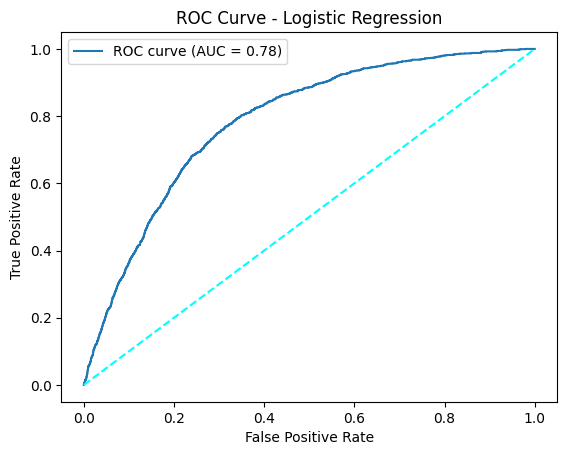

In [42]:
roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC AUC Score: {roc_auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='cyan')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.show()

In [ ]:
### Interpretation of Model Performance

Accuracy is not a sufficient metric in this context because class imbalance can mask poor performance on the minority class. Instead, recall is emphasized for eligible passengers to reduce the likelihood of incorrectly denying lounge access.

This tradeoff results in a higher number of false positives, which may increase lounge crowding but improves customer experience by minimizing wrongful denials. The ROC-AUC score provides an overall measure of the model’s ability to distinguish between eligible and ineligible passengers across different thresholds.

In [ ]:
### Limitations

This analysis is based on historical passenger data and does not capture real-time operational constraints such as lounge capacity or staffing levels. Additionally, the model assumes independence between observations and does not account for repeated passengers or temporal effects.

The results are predictive rather than causal and should be interpreted as decision support rather than definitive eligibility rules.